In [1]:
# создание загрузочных ссылок из яндекс-диска

import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key1 = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'  # groups.csv
public_key2 = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'  # groups_add.csv
public_key3 = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'  # active_studs.csv
public_key4 = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'  # checks.csv

# Получаем загрузочные ссылки
final_url1 = base_url + urlencode(dict(public_key=public_key1))
response1 = requests.get(final_url1)
download_url1 = response1.json()['href']

final_url2 = base_url + urlencode(dict(public_key=public_key2))
response2 = requests.get(final_url2)
download_url2 = response2.json()['href']

final_url3 = base_url + urlencode(dict(public_key=public_key3))
response3 = requests.get(final_url3)
download_url3 = response3.json()['href']

final_url4 = base_url + urlencode(dict(public_key=public_key4))
response4 = requests.get(final_url4)
download_url4 = response4.json()['href']


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import norm

from tqdm.auto import tqdm


%matplotlib inline

sns.set(rc={'figure.figsize':(16,6)},style='whitegrid')

# Задание 1. A/B–тестирование

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

    groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
    groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [3]:
# загружаем данные в таблицы
groups = pd.read_csv(download_url1, sep = ';')
groups_add = pd.read_csv(download_url2)
active_studs = pd.read_csv(download_url3)
checks = pd.read_csv(download_url4, sep = ';')

Изучаю данные: размер, есть ли пропущенный данные, и смотрю структуру данных через head()

In [4]:
print(groups.shape)
print(groups.isnull().sum())
groups.head()


(74484, 2)
id     0
grp    0
dtype: int64


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
print(groups_add.shape)
print(groups_add.isnull().sum())
groups_add.head()

(92, 2)
id     0
grp    0
dtype: int64


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [6]:
print(active_studs.shape)
print(active_studs.isnull().sum())
active_studs.head()

(8341, 1)
student_id    0
dtype: int64


,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [7]:
print(checks.shape)
print(checks.isnull().sum())
checks.head()

(541, 2)
student_id    0
rev           0
dtype: int64


,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


Гипотеза:
Изменение механики оплаты - увеличит конверсию покупок и/или средний чек покупателей.

Будем рассматривать качественную метрику - конверсию (количество оплативших на общее количество активных) - СR,
а также количественную метрику - средний чек купивших пользователей.

Активные - все, кто заходил в дни проведения теста.

Нулевая гипотеза - Н0 - Изменение механики оплаты не изменит конверсию и средний чек. Наблюдаемые различия - случайны
Альтернативная гипотеза - Н1 - Изменение механики оплаты изменит конверсию и средний чек. Выявленные различия - результат изменений механики оплаты


In [8]:
# проверим данные на наличие дупликатов
def duplic(data,column):
    d = data.shape[0]-data[column].nunique()
    return d

print(f'В данных groups в колонке id дупликатов: {duplic(groups,"id")}')
print(f'В данных active_studs в колонке student_id дупликатов: {duplic(active_studs,"student_id")}')
print(f'В данных checks в колонке student_id дупликатов: {duplic(checks,"student_id")}')

В данных groups в колонке id дупликатов: 0
В данных active_studs в колонке student_id дупликатов: 0
В данных checks в колонке student_id дупликатов: 0


In [9]:
# соберем в единый датасет активные пользователи, их группы, и сумму оплаты
active_studs_groups = active_studs.merge(groups,left_on='student_id',right_on='id')
del active_studs_groups['id'] # удалим дублирующую колонку

active_studs_groups_checks = active_studs_groups.merge(checks,how='left',on='student_id')
active_studs_groups_checks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8328 entries, 0 to 8327
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8328 non-null   int64  
 1   grp         8328 non-null   object 
 2   rev         391 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 260.2+ KB


In [10]:
# заполним пропуски в rev нулями и добавим колонку CR
active_studs_groups_checks.fillna(0,inplace=True)
active_studs_groups_checks['cr'] = np.where(active_studs_groups_checks['rev']>0, 1, 0)

In [11]:
active_studs_groups_checks.head()

,student_id,grp,rev,cr
0,581585,A,0.0,0
1,3276743,B,0.0,0
2,4238589,A,0.0,0
3,4475369,B,0.0,0
4,5481015,B,0.0,0


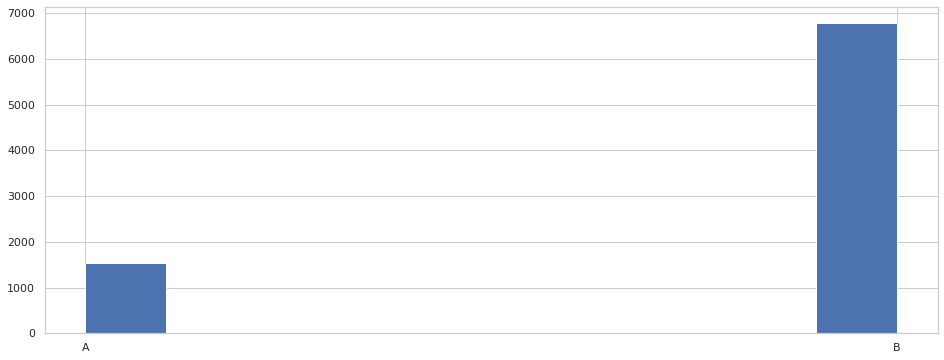

In [12]:
# посмотрим как распределены группы

active_studs_groups_checks.grp.hist()

# целевой(тестовой) группы намного больше контрольной

In [13]:
# посмотрим количество студентов в группах
active_studs_groups_checks.grp.value_counts()

B    6793
A    1535
Name: grp, dtype: int64

In [14]:
# считаем CR для групп
active_studs_groups_checks.groupby('grp').cr.mean().reset_index()

,grp,cr
0,A,0.050814
1,B,0.046077


In [15]:
# создаем таблицу с вычисленными метриками

metrics_table = active_studs_groups_checks.groupby('grp').cr.mean().reset_index()
metrics_table.insert(0, "date_of_analyse", '2023-04-01')

metrics_table

,date_of_analyse,grp,cr
0,2023-04-01,A,0.050814
1,2023-04-01,B,0.046077


Видим, что конверсия на покупку в тестовой группе уменьшилась. 
Так как СR - параметрический признак, статистическая ли разница проверим с помощью хи-квадрат.

In [16]:
# построим таблицу сопряженности
cross_tab_cr = pd.crosstab(active_studs_groups_checks.grp,active_studs_groups_checks.cr)

In [17]:
cross_tab_cr


cr,0,1
grp,,
A,1457,78
B,6480,313


In [18]:

res = chi2_contingency(cross_tab_cr)
res[1]

0.46803677583199144

Вывод: Полученные различия в CR случайны. Изменение в механике оплаты не влияет на конверсию в покупку.

Для проверки количественного параметра ARPAU - проверим на нормальность распределения.  
Если нормально, то воспользуемся t-критерием Стьюдента  
Если ненормально, то u-критерием Манна_Уитни

In [19]:
from scipy import stats
stats.shapiro(active_studs_groups_checks[active_studs_groups_checks.grp == 'B'].query('rev>0').rev)

ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)

In [20]:
stats.shapiro(active_studs_groups_checks[active_studs_groups_checks.grp == 'A'].query('rev>0').rev)

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)

Как видно тест Шапиро-Уилка на нормальность, показал, что распределения ненормально.
Трансформируем данные логарифмированием.

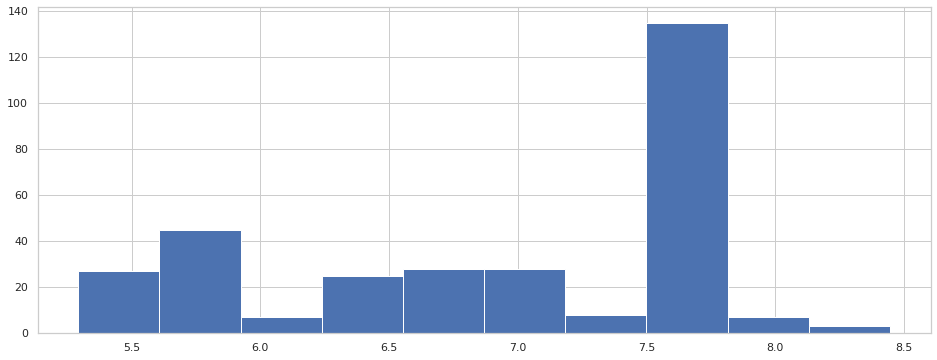

In [21]:
np.log(active_studs_groups_checks[active_studs_groups_checks.grp == 'B'].query('rev>0').rev).hist()

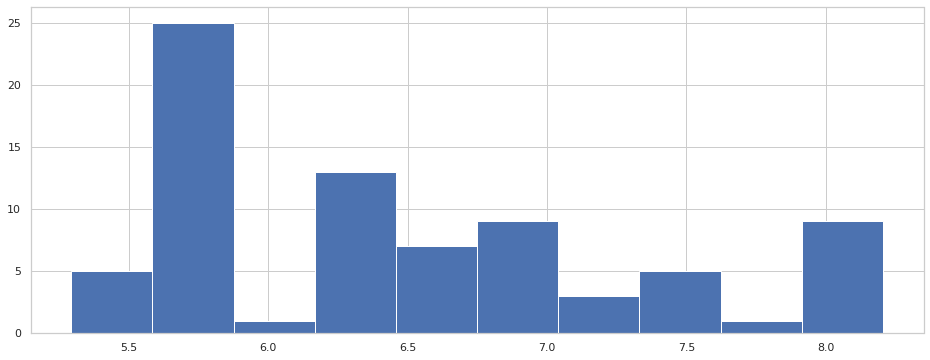

In [22]:
np.log(active_studs_groups_checks[active_studs_groups_checks.grp == 'A'].query('rev>0').rev).hist()

Полученное преобразование не привело к нормальному распределению.

In [23]:
# посчитаем ARPAU для контрольной и тестовой групп
active_studs_groups_checks.query('rev>0').groupby('grp').agg({'rev': 'mean'}).reset_index().round({'rev':2})

,grp,rev
0,A,933.59
1,B,1255.83


In [24]:
# добавим данные в таблицу метрик
metrics_table ['mean_check'] = active_studs_groups_checks.query('rev>0').groupby('grp').agg({'rev': 'mean'}).reset_index().round({'rev':2}).rev
metrics_table

,date_of_analyse,grp,cr,mean_check
0,2023-04-01,A,0.050814,933.59
1,2023-04-01,B,0.046077,1255.83


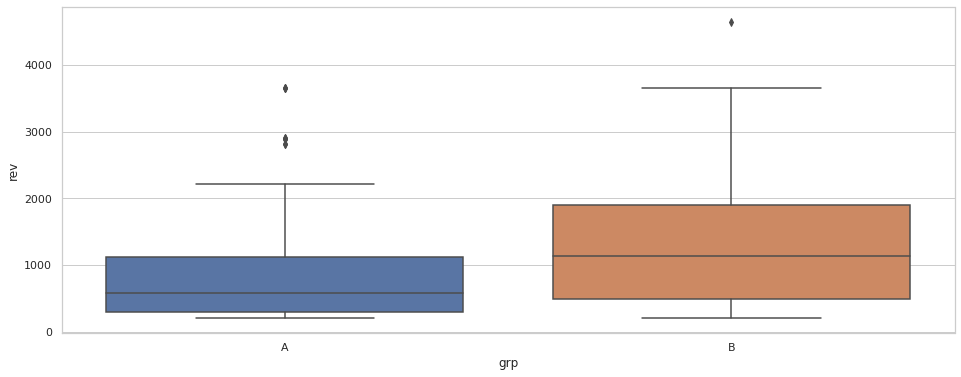

In [25]:
# построим boxplot
sns.boxplot(x="grp", y="rev", data=active_studs_groups_checks.query('rev>0'))

In [26]:
group1 = (active_studs_groups_checks[active_studs_groups_checks.grp == 'A'].query('rev>0').rev)
group2 = (active_studs_groups_checks[active_studs_groups_checks.grp == 'B'].query('rev>0').rev)

In [27]:
stats. mannwhitneyu (group1, group2)

MannwhitneyuResult(statistic=8990.0, pvalue=0.000273244700505943)

## Вывод:

После изучения полученных данных выдвигаем гипотезу.

    Гипотеза:
    Изменение механики оплаты - увеличит конверсию покупок и/или средний чек покупателей.

Будем рассматривать качественную метрику - конверсию (количество оплативших на общее количество активных) - СR,
а также количественную метрику - средний чек купивших пользователей.

Активные - все, кто заходил в дни проведения теста.

Нулевая гипотеза - Н0 - Изменение механики оплаты не изменит конверсию и средний чек. Наблюдаемые различия - случайны
Альтернативная гипотеза - Н1 - Изменение механики оплаты изменит конверсию и средний чек. Выявленные различия - результат изменений механики оплаты

Для обоих групп(контрольной "А" и тестовой "В") получены следующие метрики 
        CR          mean_check
A    0.050814        933.59
B    0.046077        1255.83

Видим, что конверсия на покупку в тестовой группе уменьшилась, а средний чек увеличился.

Так как в нашем случае СR категоримальный признак, статистический анализ проводим с помощью хи-квадрат. Полученный результат p_value = 0.46803677583199144, говорит, что наблюдаемые значения в CR случайны

Для количественного параметра mean_check была проведена проверка на нормальность распределения значений с помощью теста Шапиро-Уилка, где было выявлено, что распределение ненормальное. А также проведено преобразование данных логарифмирование, что тоже не привело к нормальному распределению данных. Было принято решение воспользоваться  u-критерием Манна_Уитни, которое показало статистическую значимость различия данных с pvalue=0.000273244700505943

С настоящими данными приходим к выводу, что данную механику оплаты запустить на всех пользователей.


# Задание 2. SQL

2.1 Очень усердные ученики.

2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

2.1.2 Задача

Дана таблица default.peas:

        Название атрибута	Тип атрибута	Смысловое значение
        st_id	                     int	ID ученика
        timest	               timestamp	Время решения карточки
        correct	                    bool	Правильно ли решена горошина?
        subject	                    text	Дисциплина, в которой находится горошина


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [28]:
import pandahouse as ph

In [29]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [30]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT COUNT(st_id) AS count_active_student
    FROM (
        SELECT st_id, SUM(correct)
        FROM peas 
        GROUP BY st_id
        HAVING SUM(correct)>=10
        )
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,count_active_student
0,233


2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:

    Название атрибута	Тип атрибута	Смысловое значение
    st_id	                     int	 ID ученика
    test_grp	                 text	 Метка ученика в данном эксперименте

и default.final_project_check:

    Название атрибута	Тип атрибута	Смысловое значение
    st_id	                     int 	ID ученика
    sale_time	           timestamp	Время покупки
    money	                     int	Цена, по которой приобрели данный курс
    subject                      text 	

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

    ARPU 
    ARPAU 
    CR в покупку 
    СR активного пользователя в покупку 
    CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.


In [31]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT test_grp, 
        ROUND(SUM(total_money)/COUNT(DISTINCT s.st_id),2) as ARPU,
        ROUND(sumIf(total_money,active_stud=1)/SUM(active_stud),2) as ARPAU,
        ROUND(countIf(total_money>0)/COUNT(DISTINCT s.st_id),2) AS CR, 
        ROUND(countIf(total_money>0 and active_stud=1)/SUM(active_stud),2) as CR_active,
        ROUND(countIf(total_money>0 and math_active=1 and bought_math=1)/SUM(math_active),2) as CR_math
    FROM studs s
    LEFT JOIN 
    (SELECT st_id, SUM(money) AS total_money,
            SUM(CASE 
            WHEN subject='Math'
            THEN 1
            ELSE 0
            END) AS bought_math
    FROM default.final_project_check
    GROUP BY st_id) AS fpc
    ON s.st_id=fpc.st_id
    LEFT JOIN (
        SELECT st_id, CASE 
            WHEN SUM(correct)>=10
            THEN 1
            ELSE 0
            END AS active_stud,
            CASE 
            WHEN countIf(subject='Math' and correct=1)>=2
            THEN 1
            ELSE 0
            END AS math_active
        FROM peas 
        GROUP BY st_id) AS acs
    ON s.st_id=acs.st_id
    GROUP BY test_grp

    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.98,10000.00,0.05,0.11,0.06
1,pilot,11508.47,28267.33,0.11,0.25,0.10


# Задание 3. Python
3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [32]:
def new_metrics(new_data,groups,active_studs,checks,next_date):
    new_data.columns=['id','grp']
    if duplic(new_data,'id')>0:
        return print('Проверьте данные. Есть дубликаты')
    groups = pd.concat([groups,new_data],ignore_index=True)
    groups.drop_duplicates('id', keep='last', inplace=True)
    
    active_studs_groups = active_studs.merge(groups,left_on='student_id',right_on='id')
    del active_studs_groups['id'] # удалим дублирующую колонку
    active_studs_groups_checks = active_studs_groups.merge(checks,how='left',on='student_id')
    
    # заполним пропуски в rev нулями и добавим колонку CR
    active_studs_groups_checks.fillna(0,inplace=True)
    active_studs_groups_checks['cr'] = np.where(active_studs_groups_checks['rev']>0, 1, 0)
    
    # высчитываем CR для каждой группы
    cr_new = active_studs_groups_checks.groupby('grp').cr.mean().reset_index().round({'cr':4})
    
    arpau = active_studs_groups_checks.query('rev>0').groupby('grp').agg({'rev': 'mean'}).reset_index().round({'rev':2})
    
    # создаем таблицу c новыми метриками
    
    new_metrics = cr_new.copy()
    new_metrics.insert(0, "date_of_analyse", next_date)
    new_metrics['mean_check'] = arpau.rev

    
    
    return new_metrics
    

In [33]:
new_metrics(groups_add,groups,active_studs,checks,'2020-13-04')

,date_of_analyse,grp,cr,mean_check
0,2020-13-04,A,0.0507,933.59
1,2020-13-04,B,0.0462,1257.88


In [44]:
def metrics_graphics(metrics):
    
    fig, ax = plt.subplots(
    2,               #две строки                                          
    1,               #по одному графику                                       
    figsize=(20, 20)  #вписать в размер 15х10 дюйма                           
    )
    
    x_labels = metrics['date_of_analyse'].unique() # значения по х
    sns.lineplot(data=metrics,x='date_of_analyse',y='cr',hue='grp',ax = ax[0])
    ax[0].set_title('CR\n')
    ax[0].set_xticklabels(x_labels,rotation = 30, ha='right')
    
    sns.lineplot(data=metrics,x='date_of_analyse',y='mean_check',hue='grp',ax = ax[1])
    ax[1].set_title('Mean_check\n')
    ax[1].set_xticklabels(x_labels,rotation = 30, ha='right')
    

In [35]:
# объединям две таблицы с метриками
nm = new_metrics(groups_add,groups,active_studs,checks,'2023-04-13')
metrics_table = pd.concat([metrics_table,nm])

In [36]:
metrics_table

,date_of_analyse,grp,cr,mean_check
0,2023-04-01,A,0.050814,933.59
1,2023-04-01,B,0.046077,1255.83
0,2023-04-13,A,0.050700,933.59
1,2023-04-13,B,0.046200,1257.88


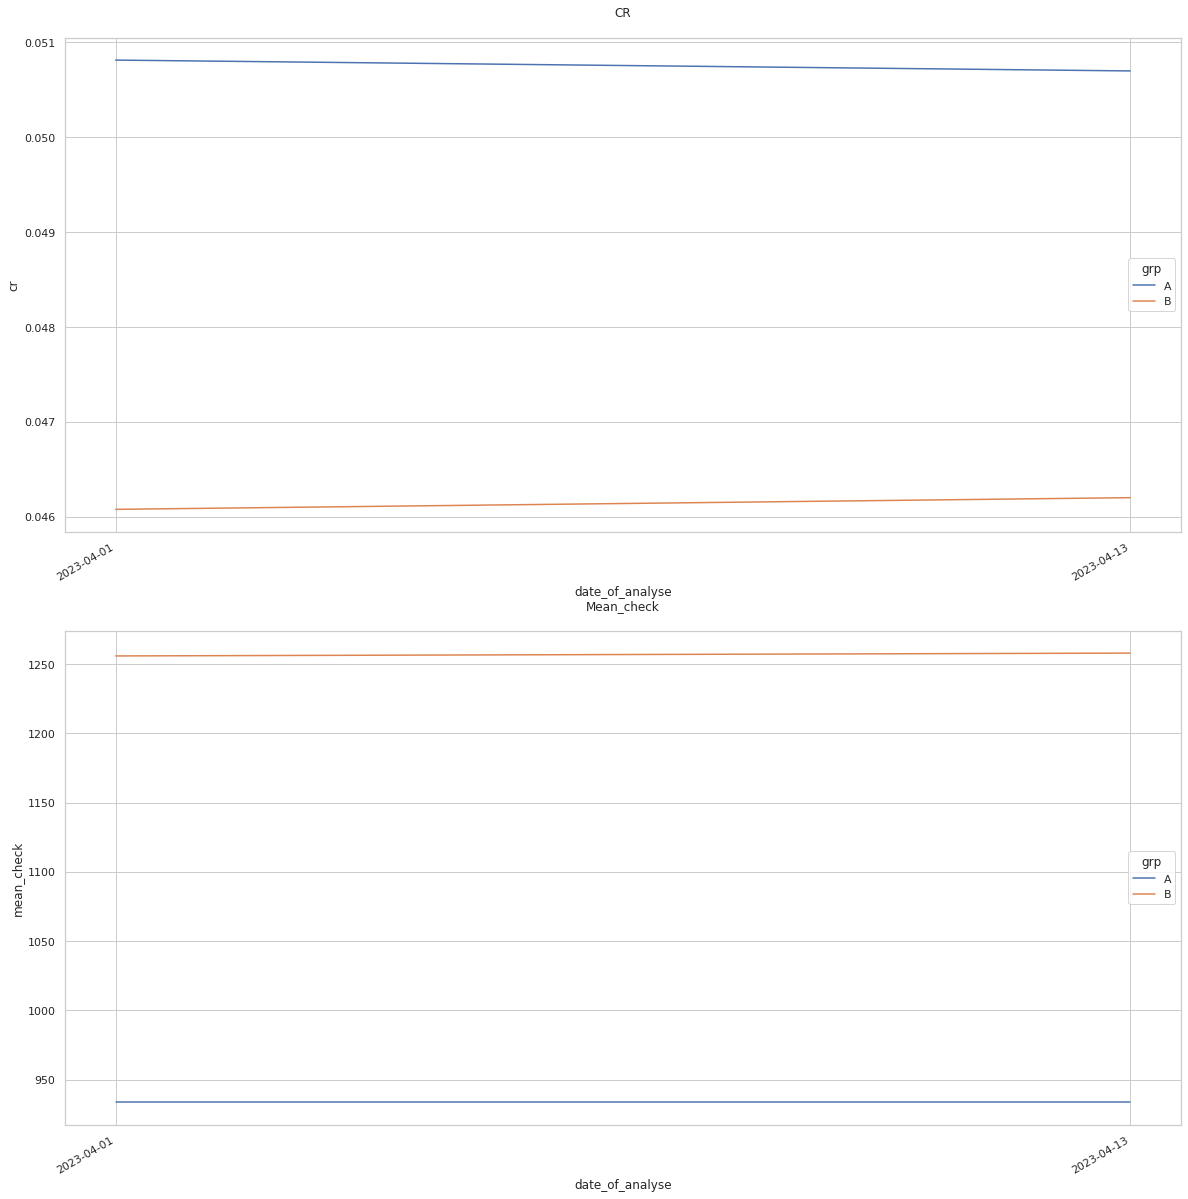

In [45]:
metrics_graphics(metrics_table)